In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os
import cv2
import math
import pandas as pd
import pickle as pk

In [2]:
#DIR = os.path.join(HOME, 'programming', 'dk39')
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39'
ORIENTED = os.path.join(DIR, 'preps', 'oriented')
CLEANED = os.path.join(DIR, 'preps', 'cleaned')
INPUT = os.path.join(DIR, 'preps', 'CH2')
OUTPUT = CLEANED
files = sorted(os.listdir(INPUT))

In [22]:
def place_image(img, max_width, max_height):
    zmidr = max_height // 2
    zmidc = max_width // 2
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]
    new_img = np.zeros([max_height, max_width])
    
    try:
        new_img[startr:endr,startc:endc] = img
    except:
        print('could not create new img', file, img.shape)
        
    return new_img.astype('uint16')


def im_type(src):
    print('dtype=',src.dtype,'shape=',src.shape)

def disp(image):
    figure(figsize=[30,8])
    im_type(image)
    imshow(image.T,'gray');


strip_max=50; strip_min=10   # the range of width for the stripe
def remove_strip(src):
    projection=np.sum(src,axis=0)/10000.
    diff=projection[1:]-projection[:-1]
    loc,=np.nonzero(diff[-strip_max:-strip_min]>50)
    mval=np.max(diff[-strip_max:-strip_min])
    #print('  ',mval,i,end=' ')
    no_strip=np.copy(src)
    if loc.shape[0]>0:
        loc=np.min(loc)
        from_end=strip_max-loc           
        #print(from_end,diff[-from_end-2:-from_end+2])
        no_strip[:,-from_end-2:]=0 # mask the strip
    return no_strip

    
    
def find_thresholdYYY(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0,0,0,0))
    n,bins,patches=ax.hist(src.flatten(),160);
    del ax, fig
    min_point=np.argmin(n[:5])
    thresh=min_point*64000/160+1000
    return min_point, thresh

def find_main_blob(stats,image):
    height,width=image.shape
    df=pd.DataFrame(stats)
    df.columns=['Left','Top','Width','Height','Area']
    df['blob_label']=df.index
    df=df.sort_values(by='Area',ascending=False)

    for row in df.iterrows():
        Left=row[1]['Left']
        Top=row[1]['Top']
        Width=row[1]['Width']
        Height=row[1]['Height']
        corners= int(Left==0)+int(Top==0)+int(Width==width)+int(Height==height)
        if corners<=2:
            return row


def scale_and_mask(src,mask,epsilon=0.01):
    vals=np.array(sorted(src[mask>10]))
    ind=int(len(vals)*(1-epsilon))
    _max=vals[ind]
    # print('thr=%d, index=%d'%(vals[ind],index))
    _range=2**16-1
    scaled=src*(45000./_max)
    scaled[scaled>_range]=_range
    scaled=scaled*(mask>10)
    return scaled,_max

def get_last_2d(data):
    if data.ndim <= 2:
        return data
    m,n = data.shape[-2:]
    return data.flat[:m*n].reshape(m,n)

def linnorm(img, limit):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    #img_norm = limit - img_norm
    return img_norm.astype('uint16')

def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0, 0, 0, 0))
    n, bins, patches = ax.hist(src.flatten(), 360);
    del ax, fig
    min_point = np.argmin(n[:5])
    min_point = int(max(2, min_point))
    thresh = (min_point * 64000 / 360) + 200
    return min_point, thresh

In [4]:
max_width = 1050
max_height = 1750
#max_width = 50100
#max_height = 34000
#1048x1738

In [5]:
print(max_width, max_height, len(files))

1050 1750 469


In [10]:
# 011.tif 109.tif 111.tif 112.tif 253.tif 466.tif 467.tif
badis = [10,108,110,111,163,228,229, 230,240,241,252,303,316,343,344,346,352,354,357,359,361,366,367,465,466]
bads = [files[i] for i in badis]

In [7]:
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

In [23]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
results=[]
strips = []
norms = []
tilesize = 8
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(tilesize, tilesize))

sfiles = [files[0]]
for i, file in enumerate(tqdm(bads)):
    infile = os.path.join(INPUT, file)
    src = io.imread(infile)
    img_inputs.append(src)
    file_inputs.append(file)
    strip_src = linnorm(src, 2**14)
    norms.append(strip_src)
    #strip_src = clahe.apply(src)
    no_strip = remove_strip(src)
    strips.append(no_strip)
    ###### Threshold it so it becomes binary
    min_point, threshold = find_threshold(no_strip)
    #print(min_point, threshold)
    #threshold = max(200, threshold)
    #print(threshold)
    #threshold = 500
    ret, threshed = cv2.threshold(no_strip,threshold,255,cv2.THRESH_BINARY)
    threshed=np.uint8(threshed)
    ###### Find connected elements
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    # Find the blob that corresponds to the section.
    row=find_main_blob(stats,src)
    blob_label=row[1]['blob_label']
    #extract the blob
    blob=np.uint8(labels==blob_label)*255
    #Perform morphological closing
    kernel10 = np.ones((10,10),np.uint8)
    closing = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    del blob
    # scale and mask
    scaled,_max=scale_and_mask(src,closing)
    del src
    scaled = place_image(scaled, max_width, max_height)
    titles.append((min_point, threshold))
    img_outputs.append(scaled)
    outpath = os.path.join(OUTPUT, file)    
    #cv2.imwrite(outpath, scaled.astype('uint16'))
print('Finished')


100%|██████████| 25/25 [00:09<00:00,  2.75it/s]

Finished


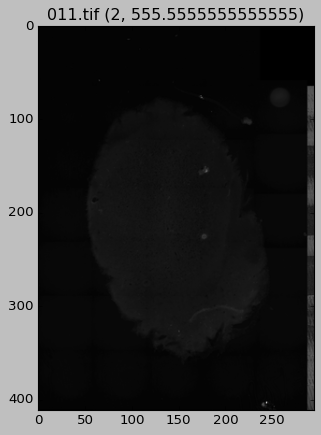

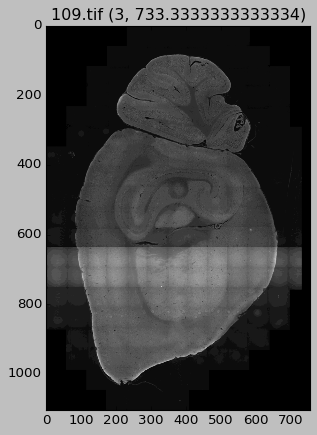

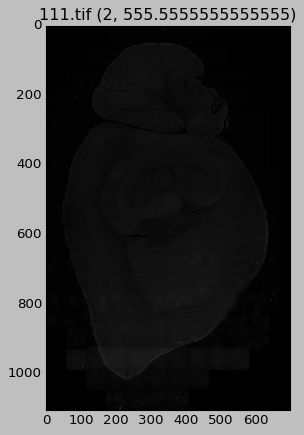

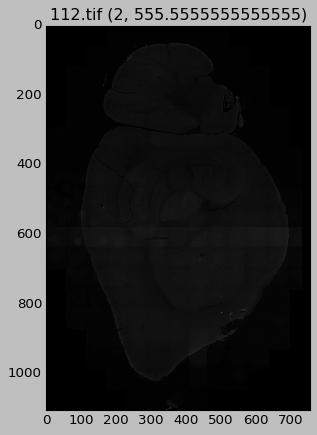

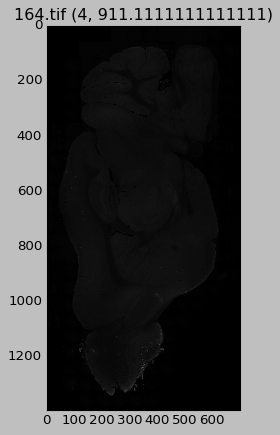

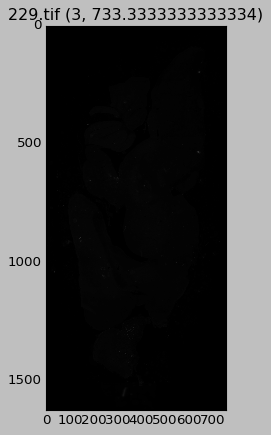

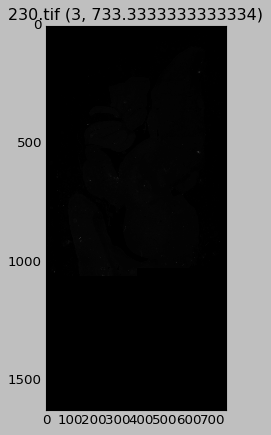

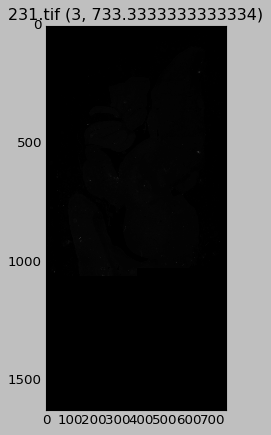

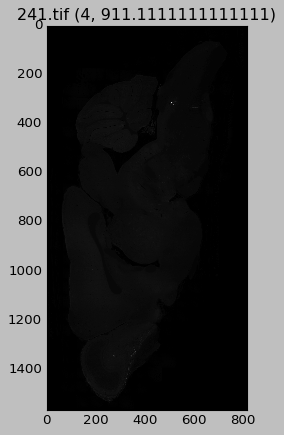

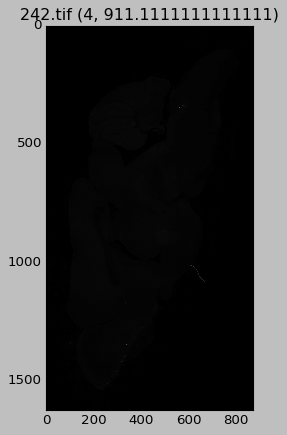

In [26]:
# display images
# check alignment
start, finish = (0,10)
displays = strips[start:finish]
tdisplays = titles[start:finish]
names = file_inputs[start:finish]
plt.style.use('classic')
for name,img,title in zip(names,displays, tdisplays):    
    plt.figure()
    plt.title('{} {}'.format(name, str(title)))
    #plt.title('{}'.format(name))
    plt.imshow(img, cmap='gray')
    plt.show()